# Array Broadcasting in Numpy
## Agenda

- Array Broadcastingのルールとメリットを押さえる

## 参考

- [vector quantization](http://www.mqasem.net/vectorquantization/vq.html)

### Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


In [2]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.15.4
BuildVersion:	19E287


### Python

In [3]:
!python -V

Python 3.7.4


### Import

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as sp

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

### Numpy version

In [5]:
np.__version__

'1.18.2'

## 1. Broadcastingとは？

shapeが異なる`numpy.ndarray`同士（または`numpy.ndarray`とarray）のarithmetic operation ruleのこと。例えば、1次元3要素の`numpy.ndarray`と１次元1要素の`numpy.ndarray`の加法を実施するとき、１次元1要素の`numpy.ndarray`がnumpy内部で１次元3要素の`numpy.ndarray`にbroadcastされ、演算結果が返ってくる。

- broadcastingはPythonではなくCベースで実施される
- 不必要なcopyが生成されることなくarithmetic operationが実施されるのでメモリ効率的とされる(例外もある)

In [6]:
## アダマール積
a = np.array([1.0, 2.0, 3.0])
b = np.array([2.0, 2.0, 2.0])
a * b

array([2., 4., 6.])

In [7]:
## broadcasting example 1
a = np.array([1.0, 2.0, 3.0])
b = list([2])
a * b

array([2., 4., 6.])

実行時間

In [8]:
%%timeit
a = np.array([1.0, 2.0, 3.0])
b = np.array([2.0, 2.0, 2.0])
a * b

2.86 µs ± 64.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [9]:
%%timeit
a = np.array([1.0, 2.0, 3.0])
b = 2.0
a * b

2.23 µs ± 106 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
## broadcasting example 2
a = np.array([[1.0, 2.0]])
b = np.array([3, 4])
print(a.shape, b.shape)
c = a + b
print(c, c.shape)

(1, 2) (2,)
[[4. 6.]] (1, 2)


### The Broadcasting Rule

```
In order to broadcast, the size of the trailing axes for both arrays in an operation must either be the same size or one of them must be one.
```

- 条件を満たさなかった場合、`a ValueError('frames are not aligned') exception`が出力される

#### Rule 1: ブロードキャスト対象の配列の中で、次元数(ndim)が異なるときは、shapeの先頭に1を入れいることで調整する

<img src = "https://github.com/RyoNakagami/omorikaizuka/blob/master/algorithm/numpy_broadcast_1.jpg?raw=true">

In [11]:
a = np.array([[ 0.0,  0.0,  0.0],
           [10.0, 10.0, 10.0],
           [20.0, 20.0, 20.0],
           [30.0, 30.0, 30.0]])
b = np.array([1.0, 2.0, 3.0])
a + b

array([[ 1.,  2.,  3.],
       [11., 12., 13.],
       [21., 22., 23.],
       [31., 32., 33.]])

#### Rule 2: 次元数が等しいとき、各次元の要素数が最も大きい値に等しい、または異なる場合どちらかがちょうど1となっているときbroadcastingは実行できる

<img src = "https://github.com/RyoNakagami/omorikaizuka/blob/master/algorithm/numpy_broadcasting_2.jpg?raw=true">

In [12]:
# 要素数が揃っている場合 Example 3
x = np.ones((1,4))
y = np.ones((3,4))
x + y

array([[2., 2., 2., 2.],
       [2., 2., 2., 2.],
       [2., 2., 2., 2.]])

In [13]:
# 要素数が揃っている場合 Example 4
x = np.ones((4))
y = np.ones((3,4))
x + y

array([[2., 2., 2., 2.],
       [2., 2., 2., 2.],
       [2., 2., 2., 2.]])

In [14]:
# 次元数が等しいが要素数が揃っていない、かつ1ではない場合 Example 5
x = np.ones((4))
y = np.ones((1,2))
x + y

ValueError: operands could not be broadcast together with shapes (4,) (1,2) 

In [15]:
# Example 6

a = np.array([0.0, 10.0, 20.0, 30.0])
b = np.array([1.0, 2.0, 3.0])
a + b

ValueError: operands could not be broadcast together with shapes (4,) (3,) 

In [16]:
a = a[:, np.newaxis]
a + b

array([[ 1.,  2.,  3.],
       [11., 12., 13.],
       [21., 22., 23.],
       [31., 32., 33.]])

### Summary

<img src = "https://github.com/RyoNakagami/omorikaizuka/blob/master/algorithm/numpy_broadcast_3.jpg?raw=true">

## 2. A Practical Example: Vector Quantization

- broadcastingはvector quantization (VQ) algorithm （K-means clusteringのセンターを見つけるアルゴリズムに類似）にて使われる

### ベクトル量子化とは?

- 観測パターンを有限個の代表的なパターンの1つ(クラスの中心点)に置き換える
- 有限個の代表的なパターンの要素のcodeといい、その集合をcodebookと呼ぶ

#### Algorithm: LBG

1. The codebookのサイズを定めそれをNとする
2. vector space $R^k$からランダムに the initial codebookを定める
3. the Euclidean distance measureを用いて、observationをそれぞれのcodeに割り当てる
4. 新しいthe set of codebookを計算する

$$
y_i = \frac{1}{m}\sum_{j=1}^mx_{ij}
$$

5. codebookが収束するまで(3), (4)を繰り返す


### Python implementation

In [17]:
def _vector_quantization(obs, code_book):
    """
        Parameters
    ----------
    obs : ndarray
        Each row of the 'N' x 'K' array is an observation.  The columns are
        the "features" seen during each observation. The features must be
        whitened first using the whiten function or something equivalent.
    
    code_book : ndarray
        'M' x 'K' array
        The code book is usually generated using the k-means algorithm.
        Each row of the array holds a different code, and the columns are
        the features of the code.
        
        Returns
    code : ndarray
        A length M array holding the code book index for each observation.
    dist : ndarray
        The distortion (distance) between the observation and its nearest
        code.
        
        REMARKS
    In case of multiple occurrences of the minimum values, the indices corresponding to the first occurrence are returned.
    """
    ct = np.common_type(obs, code_book)
    c_obs = obs.astype(ct, copy=False)
    c_code_book = code_book.astype(ct, copy=False)
    
    M = code_book.shape[0]
    N = obs.shape[0]
    
    cdist= np.array([])
    for i in range(M):
        cdist = np.append(cdist, np.sqrt(np.sum((obs - code_book[i, :])**2, axis = 1)))
    dist = cdist.reshape(M, -1)
    code = np.argmin(dist, axis  = 0)
    min_dist = dist[code, np.arange(N)]
    
    return code, min_dist

def vector_quantization(obs, code_book, iter=100000, thresh=1e-9):
    M = code_book.shape[0]
    update_code_book = code_book.copy()
    for i in range(iter):
        code, min_dist = _vector_quantization(obs, update_code_book)
        for i in range(M):
            _array = obs[code == i,:]
            if _array.size == 0.:
                continue
            update_code_book[i, :] = np.mean(_array, axis = 0)
        
        if np.allclose(update_code_book, code_book):
            return code, min_dist, update_code_book
        else:
            code_book = update_code_book

    return code, min_dist, update_code_book

### Test

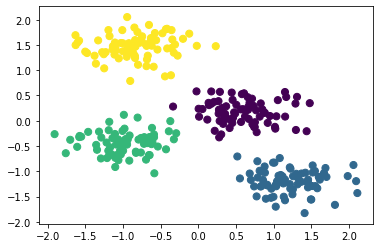

In [18]:
## Generate Data
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
X = sp.stats.zscore(X, axis=0)
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=50, cmap='viridis');

In [19]:
np.random.seed(42)
initial_guess = np.array([[-2.0, -2.0],
                          [-2.0, 2.0],
                          [2.0, -2.0],
                          [2.0, 2.0]])

In [20]:
code, min_dist, update_code_book = vector_quantization(obs = X, code_book = initial_guess)

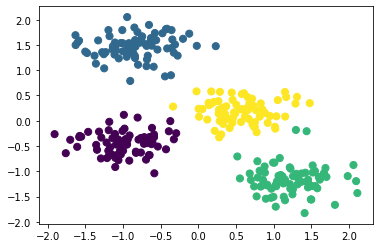

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=code, s=50, cmap='viridis');

### REMARKS

- 初期値の選び方とdataの正規化が重要となる（別の機会で取り扱う）